In [ ]:
## Experiment performed by:
## Akshunn Garg 23/CS/042


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 2.1 MB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 2.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Spam Classification via Naive Bayes

### Importing Necessary Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
import re
import emoji
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to C:\Users\Akshunn
[nltk_data]     Garg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Imporing the Dataset

In [13]:
df = pd.read_csv("spam.csv", encoding="latin1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Exploratory Data Analysis

In [14]:
## Checking the shape of the dataset
df.shape

(5572, 5)

In [15]:
## Checking for null values
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [16]:
## Checking for any duplicate rows
df.duplicated().any()

True

In [17]:
## Eliminating the duplicate rows
df = df.drop_duplicates()

In [22]:
## Confirming the elimination of the duplicate rows
df.duplicated().any()
print(df.columns)
df = df.rename(columns={"v1": "Category", "v2": "Message"})
df = df[["Category", "Message"]]

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


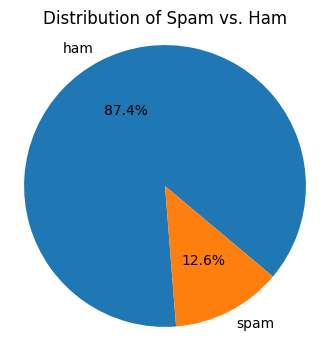

In [23]:
## Calculate the count of each label
category_counts = df['Category'].value_counts()

## Plotting the pie chart
plt.figure(figsize=(4,4))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=320)
plt.title('Distribution of Spam vs. Ham')
plt.axis('equal')  
plt.show()

### Text Visualisation

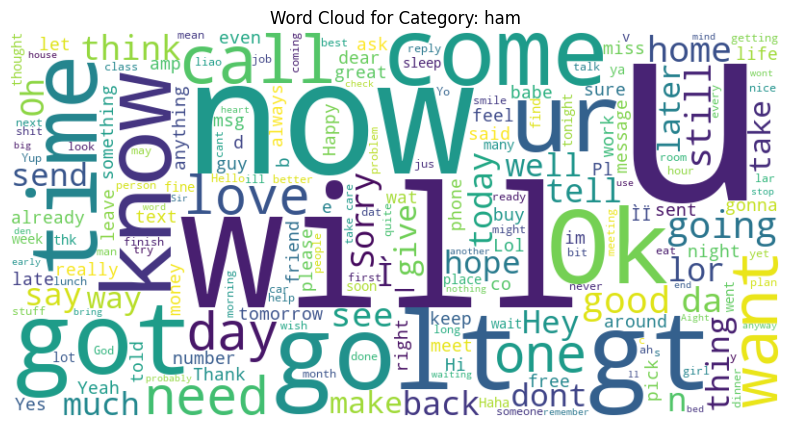

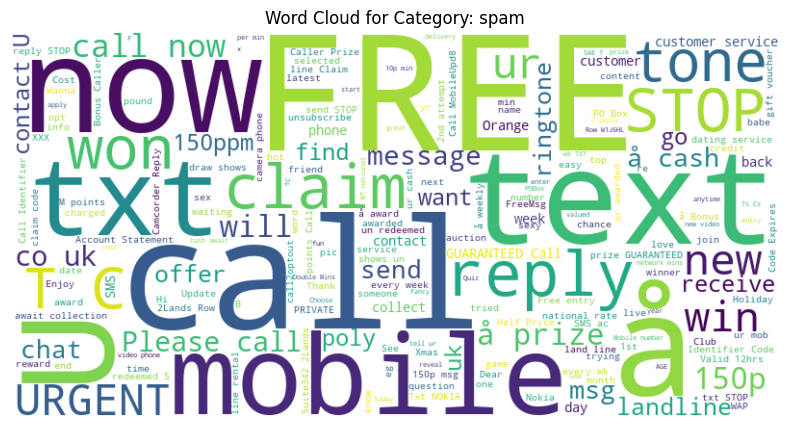

In [24]:
## Iterate through unique categories
for category in df['Category'].unique():
    # Filter the DataFrame for the current category
    filtered_df = df[df['Category'] == category]

    # Concatenate all text data for the current category
    text = ' '.join(filtered_df['Message'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()

### Encoding

In [25]:
## Encoding ham(not spam) as 0 and spam as 1
le = LabelEncoder()
df['Category']=le.fit_transform(df['Category'])
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Text Preprocessing

We will apply the following operations for the cleaning of the text: 

    Lower Casing

    Remove HTML Tags

    Remove URLs

    Replacing Emojis with text description

    Removal of Special Characters (for correct expansion of any chat words)

    Expand Chat Words

    Remove Special Characters (any special characters left)

    Remove Numeric Values

    Handling StopWords

    Normalize white spaces

    Stemming

In [26]:
## Convert 'Message' column to lowercase and make a new column "Cleaned_Message"
df["Cleaned_Message"] = df["Message"].str.lower()
df.head()

,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."


In [27]:
## Function to remove HTML tags from text
def remove_html_tags(text):
    return re.sub(r"<[^>]*>", " ", text)

## Remove HTML tags from "Cleaned Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_html_tags)
df.head()

,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."


In [28]:
## Function to remove URLs using regular expressions
def remove_urls(text):
    return re.sub(r"http\S+|www\.\S+", " ", text)

## Apply the function to the "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_urls)
df.head()

,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."


In [29]:
## Function to convert emoji to text descriptions
def replace_emojis(text):
    return emoji.demojize(text, language="en")

## Apply replace_emojis function to "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(replace_emojis)
df.head()

,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."


In [30]:
## Function to remove the special characters
def remove_special_characters(text):
    return re.sub(r"[^0-9a-zA-Z\s]", " ", text)

## Apply the function to the "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_special_characters)
df.head()

,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives aro...


In [31]:
## Dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My Ass Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The Ass",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My Ass Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [32]:
## Function to expand the chat words

def replace_chat_words(text):
    words = text.split()  # split text into words
    new_words = []
    for word in words:
        if word.upper() in chat_words:
            new_words.append(chat_words[word.upper()])
        else:
            new_words.append(word)
    return " ".join(new_words)

## Apply replace_chat_words function to "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(replace_chat_words)
df.head()

,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,You dun say so early hor You c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


In [33]:
## Function to remove the special characters
def remove_special_characters(text):
    return re.sub(r"[^0-9a-zA-Z\s]", " ", text)

## Apply the function to the "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_special_characters)
df.head()

,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,You dun say so early hor You c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


In [34]:
## Function to remove the numeric characters
def remove_numeric_characters(text):
    return re.sub(r"\d+", " ", text)

## Apply the function to the "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_numeric_characters)
df.head()

,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,You dun say so early hor You c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


In [35]:
## Removing the stopwords
all_stop_words = stopwords.words('english')
all_stop_words.remove('not') ## as 'not' is important in classification

## Function to remove the stop words
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if(word not in all_stop_words)]
    return " ".join(filtered_words)

## Applying the function to "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_stop_words)
df.head()

,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,You dun say early hor You c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though


In [36]:
## Remove extra white spaces from the 'Text' column
def remove_extra_whitespaces(text):
    return re.sub(r"\s+", " ", text).strip()
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_extra_whitespaces)
df.head()

,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,You dun say early hor You c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though


In [37]:
## Applying stemming
ps = PorterStemmer()

def stem_words(text):
    words = text.split(' ')
    stemmed_words = [ps.stem(word) for word in words]
    return " ".join(stemmed_words)

## Applying the function to "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(stem_words)
df.head()

,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif you oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,0,U dun say so early hor... U c already then say...,you dun say earli hor you c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


## Implementing Naive Bayes

In [38]:
class MyNaiveBayes():
    def __init__(self):
        pass
    
    ## alpha refers to the smoothing paramter in Laplace Smoothing (by default it is 1)
    def fit(self, x_train, y_train, alpha = 1):
        self.alpha = alpha
        m, self.V = x_train.shape ## number of instances, number of different words
        self.word_track = np.zeros((2, self.V)) ## for 2 classes
        for i in range(m):
           self.word_track[y_train[i]]+=x_train[i]
        self.class_priors = []
        for c in [0,1]:
            self.class_priors.append(np.log(np.mean(y_train == c)))


    def predict(self, x_test):
        y_pred = []
        sum_0 = np.sum(self.word_track[0])
        sum_1 = np.sum(self.word_track[1])
        for sentence in x_test:
            class_probab = [self.class_priors[0], self.class_priors[1]]
            for idx, occ in enumerate(sentence):
                if(occ>0):
                    class_probab[0]+=occ*np.log((self.alpha + self.word_track[0][idx])/(self.alpha*self.V + sum_0))
                    class_probab[1]+=occ*np.log((self.alpha + self.word_track[1][idx])/(self.alpha*self.V + sum_1))
            y_pred.append(np.argmax(class_probab))
        return np.array(y_pred)

### Train Test Split

In [39]:
## We do train–test split before vectorization to prevent data leakage, ensuring the test set words don’t influence the training vocabulary.

x = df["Cleaned_Message"].to_numpy()
y = df["Category"].to_numpy()

In [40]:
x_train, x_test , y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [41]:
x_train.shape

(4135,)

In [42]:
x_test.shape

(1034,)

In [43]:
y_train.shape

(4135,)

In [44]:
y_test.shape

(1034,)

## Using CountVectorizer

In [45]:
vectorizer=CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train).toarray()
x_test_vec = vectorizer.transform(x_test).toarray()

### Comparing performances of different values of alpha

Alpha=0.5
  Accuracy=0.976, Precision=0.917, Recall=0.910, F1=0.913
--------------------------------------------------
Alpha=1.0
  Accuracy=0.978, Precision=0.936, Recall=0.903, F1=0.919
--------------------------------------------------
Alpha=5.0
  Accuracy=0.977, Precision=0.984, Recall=0.848, F1=0.911
--------------------------------------------------


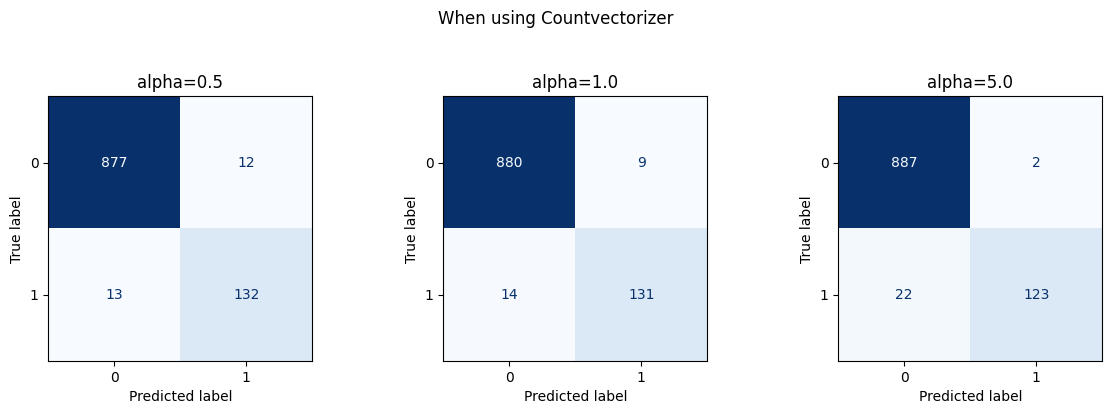

In [46]:
alphas = [0.5, 1.0, 5.0]   
plt.figure(figsize=(12,4))  
plt.suptitle("When using Countvectorizer\n\n")

for i, alpha in enumerate(alphas, 1):
    model = MyNaiveBayes()
    model.fit(x_train_vec, y_train, alpha=alpha)
    y_pred = model.predict(x_test_vec)

    # Metrics
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="binary")
    recall    = recall_score(y_test, y_pred, average="binary")
    f1        = f1_score(y_test, y_pred, average="binary")

    print(f"Alpha={alpha}")
    print(f"  Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    print("-"*50)

    ## Making the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(1, 3, i)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", colorbar=False, ax=ax)
    ax.set_title(f"alpha={alpha}")

plt.tight_layout()
plt.show()

## Using TfidfVectorizer

In [47]:
vectorizer=TfidfVectorizer()
x_train_vec = vectorizer.fit_transform(x_train).toarray()
x_test_vec = vectorizer.transform(x_test).toarray()

### Comparing performances of different values of alpha

Alpha=0.5
  Accuracy=0.973, Precision=0.976, Recall=0.828, F1=0.896
--------------------------------------------------
Alpha=1.0
  Accuracy=0.966, Precision=0.991, Recall=0.766, F1=0.864
--------------------------------------------------
Alpha=5.0
  Accuracy=0.879, Precision=1.000, Recall=0.138, F1=0.242
--------------------------------------------------


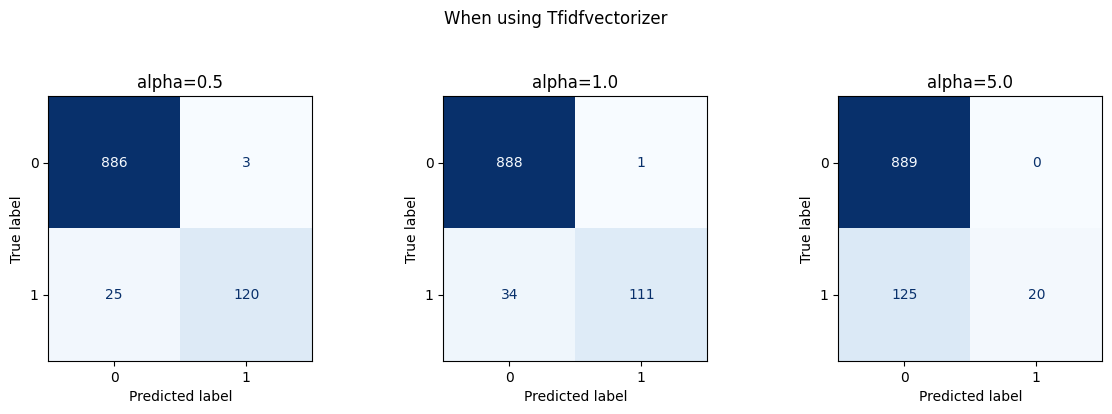

In [48]:
alphas = [0.5, 1.0, 5.0]   
plt.figure(figsize=(12,4))
plt.suptitle("When using Tfidfvectorizer\n\n")

for i, alpha in enumerate(alphas, 1):
    model = MyNaiveBayes()
    model.fit(x_train_vec, y_train, alpha=alpha)
    y_pred = model.predict(x_test_vec)

    # Metrics
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="binary")
    recall    = recall_score(y_test, y_pred, average="binary")
    f1        = f1_score(y_test, y_pred, average="binary")

    print(f"Alpha={alpha}")
    print(f"  Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    print("-"*50)

    ## Making the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(1, 3, i)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", colorbar=False, ax=ax)
    ax.set_title(f"alpha={alpha}")

plt.tight_layout()
plt.show()

## Comparing Logistic Regression with Naive Bayes

In [49]:
results = {
    "Model": ["Logistic Regression", "Logistic Regression", "Naive Bayes", "Naive Bayes"],
    "Vectorizer": ["Count", "TF-IDF", "Count", "TF-IDF"],
    "Reg. λ": [0.1, 0.1, "-", "-"],
    "Accuracy": [0.98, 0.98, 0.98, 0.96],
    "Precision": [0.89, 0.89, 0.92, 1.00],
    "Recall": [0.96, 0.96, 0.94, 0.74],
    "F1": [0.93, 0.93, 0.93, 0.85]
}

df_results = pd.DataFrame(results)
print(df_results)


                 Model Vectorizer Reg. λ  Accuracy  Precision  Recall    F1
0  Logistic Regression      Count    0.1      0.98       0.89    0.96  0.93
1  Logistic Regression     TF-IDF    0.1      0.98       0.89    0.96  0.93
2          Naive Bayes      Count      -      0.98       0.92    0.94  0.93
3          Naive Bayes     TF-IDF      -      0.96       1.00    0.74  0.85
